# Training a 3D CNN

In [1]:
from faimed3d.basics import *
from faimed3d.augment import *
from faimed3d.models import *
from faimed3d.data import *

import pathlib
import re
from fastai.basics import *
from fastai.vision.data import *

## Loading the data

In [2]:
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')
test = pathlib.Path('../../dl-prostate-mapping/data/test')

train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))
test_files = list(test.rglob('DICOM'))

# take only T2 and T1 images for noe
subset_train =[]
for f in train_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_train.append(Path(m.string))
        
subset_valid =[]
for f in valid_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_valid.append(Path(m.string))
        
subset_test = []
for f in test_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_test.append(Path(m.string))
        
        
def label_func(fn):
    return re.findall(r'(Gesund|ProstataCa)', str(fn))[0]
labels = ['Gesund', 'ProstataCa']

In [3]:
oversampled_train = subset_train +  subset_valid 

## Setting up dataloaders

In [4]:
labels = ['Gesund', 'ProstataCa']
def label_func(fn): return re.findall(r'(Gesund|ProstataCa)', str(fn))[0]

In [5]:
mris = DataBlock(
            blocks = (ImageBlock3D(cls=TensorDicom3D), 
                      CategoryBlock),
            get_x = lambda x: x,
            get_y = label_func, 
            item_tfms = ResizeCrop3D(crop_by = (0., 0.14, 0.14), resize_to = (20, 160, 160), perc_crop = True),
            batch_tfms = [*aug_transforms_3d(p_all =1.), RandomCrop3D((0, 25, 25), (0, 15, 15)), PseudoColor],
            splitter = RandomSplitter())

In [6]:
dls = mris.dataloaders(source = oversampled_train, 
                      num_workers = 0, 
                      batch_size = 16)
dls.valid.bs = 8 # fastai takes a larger bs for valid dset, however for 3D this is to large

In [7]:
class Sequential_(nn.Sequential):
    "Somehow, in 3D CNNs, the input is not transfered to cuda. I believe something in the transforms is wrong. Until this is fixed, subcalssing nn.Sequential is the workarround"
    def forward(self, input):
        for module in self:
            input = module(input.cuda())
        return input

def block(ni, nf, **kwargs): 
    return Sequential_(
        ResBlock(1, ni, nf, stride = (2,2,1), ndim = 3, **kwargs), 
        ResBlock(1, nf, nf, ndim = 3))

#def block(ni, nf, **kwargs): return ConvLayer(ni, nf, ndim = 3, **kwargs)

def get_model():
    return Sequential_(
        block(20, 64, ks = 7),
        block(64, 128, ks = 5),
        block(128, 256),
        nn.AdaptiveAvgPool3d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [8]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [9]:
auc = RocAucBinary()

In [10]:
from fastai.callback.hook import *

In [11]:
learn = Learner(dls, get_model(), opt_func = SGD, loss_func = loss_func, metrics=[error_rate, auc], cbs=ActivationStats(with_hist=True))
learn = learn.to_fp16()

In [12]:
#learn.lr_find()

In [13]:
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.005)

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.770309,0.696321,0.590909,0.547009,00:39
1,0.772107,0.702593,0.590909,0.564103,00:34
2,0.774382,0.707116,0.590909,0.581197,00:34
3,0.766831,0.713581,0.590909,0.547009,00:34
4,0.762790,0.719228,0.590909,0.487179,00:34
5,0.758593,0.721603,0.590909,0.461538,00:34
6,0.754313,0.716621,0.590909,0.427350,00:34
7,0.748770,0.706238,0.590909,0.452991,00:34
8,0.741909,0.703045,0.545455,0.444444,00:34
9,0.736479,0.698690,0.545455,0.376068,00:34


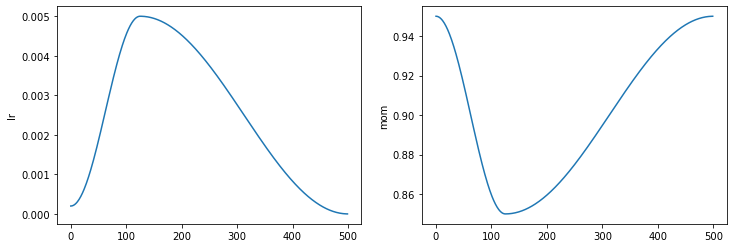

In [14]:
learn.recorder.plot_sched()

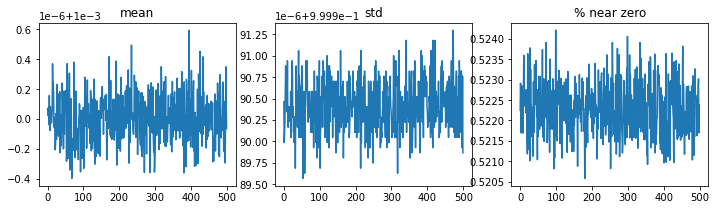

In [15]:
learn.activation_stats.plot_layer_stats(-4)

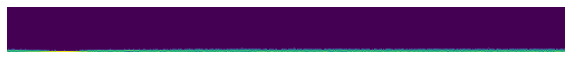

In [16]:
learn.activation_stats.color_dim(-1)